The MIT License (MIT)<br>
Copyright (c) 2016,2017 Massachusetts Institute of Technology

Author: Justin Li<br>
This software is part of the NASA AIST Project "Computer-Aided Discovery of<br>
Earth Surface Deformation Phenomena" , PI: V. Pankratius

Permission is hereby granted, free of charge, to any person obtaining a copy<br>
of this software and associated documentation files (the "Software"), to deal<br>
in the Software without restriction, including without limitation the rights<br>
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell<br>
copies of the Software, and to permit persons to whom the Software is<br>
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in<br>
all copies or substantial portions of the Software.<br>
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR<br>
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,<br>
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE<br>
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER<br>
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,<br>
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN<br>
THE SOFTWARE.

# Volcano Case Study - Analysis Demonstration
A demonstration of the code used for the scientific analysis of transient event detection in Alaskan volcanoes, using as a specific example Akutan volcano (Akutan Island, Alaska).
- Highlights the usage of our skdaccess and skdiscovery packages
- Includes comment blocks showing how the scientist provides expertise as the code runs
- Generates results that are in submission to publication

For details, see <br>
<b>Computer Aided Detection of Transient Inflation Events at Alaska Volcanoes using GPS Measurements from 2005-2015</b><br>
Justin Li, Cody Rude, David Blair, Michael Gowanlock, Thomas Herring, Victor Pankratius<br> published in Journal of Volcanology and Geothermal Research, May 2016

In [1]:
# Imports
# Standard libraries and notebook plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 6.0)
from IPython.display import display
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter("ignore")

# skdaccess PBO Data Fetcher and param class
from skdaccess.geo.pbo import DataFetcher as PBODF
from skdaccess.framework.param_class import *

# skdiscovery analysis items
from skdiscovery import DiscoveryPipeline
from skdiscovery.framework.stagecontainers import *
import skdiscovery.table.filters
import skdiscovery.table.analysis
import skdiscovery.table.accumulators
import skdiscovery.series.filters
import skdiscovery.series.analysis
import skdiscovery.series.accumulators
import skdiscovery.generic.accumulators

#### Uses the skdaccess package to load the PBO data at Akutan 

In [2]:
# Region of interest for overall GPS station, all of Alaska, for stabilization
pbo_lat_range = AutoList([50,75])
pbo_lon_range = AutoList([-175, -130])

# Time range of data of interest
start_time = '2006-01-01'
end_time = '2015-06-01'

# Akutan Volcano, Akutan Island, Alaska
ap_lat = AutoParam(54.13308)
ap_lon = AutoParam(-165.98555)
# Radius of circle of interest (km)
ap_radius = AutoParam(15)

# Retrieve station metadata
pbo_metadata = PBODF.getStationMetadata()

# Create the Data Fetcher to load the data
data_generator = PBODF(start_time, end_time, [pbo_lat_range, pbo_lon_range])

#### Uses the skdiscovery package to build an analysis pipeline 

In [3]:
# Geo Location Filter for selecting data within defined region of interest
fl_geo = skdiscovery.table.filters.GeoLocationFilter('GeoFilter',[ap_lat, ap_lon, ap_radius])
# Stage container for filter
sc_geo = StageContainer(fl_geo)

# Create Stabilization Filter for stabilizing a region
fl_stab = skdiscovery.table.filters.StabilizationFilter('StabFilter')
# Stage container for filter
sc_stab = StageContainer(fl_stab)

# Create Trend Filter to remove linear, annual, and semi-annual trend
fl_tf = skdiscovery.table.filters.TrendFilter('TrendFilter', [])
# Create stage container for the trend filter
sc_tf = StageContainer(fl_tf)

# Set tau
ap_kf_tau = AutoParam(120)
# Set Sigma Squared
ap_kf_sigmasq = AutoParam(4)
# Set R
ap_kf_R = AutoParam(1)
# Create Kalman Smoother
fl_kf = skdiscovery.table.filters.KalmanFilter('Kalman Smoother', [ap_kf_tau, ap_kf_sigmasq, ap_kf_R])
# Create stage container for Kalman filter
sc_kf = StageContainer(fl_kf)

# Principal Component Analysis with specified time window
# Set start time
ap_pca_start = AutoParam('2006-06-01')
# Set end time
ap_pca_end = AutoParam('2015-01-01')
# Set number of components
ap_pca_type = AutoParam('PCA')
# Set column names to use
pca_column_names = ('dN','dE')
# Create PCA analysis item
ana_gca = skdiscovery.table.analysis.General_Component_Analysis('PCA', [ap_pca_type, ap_pca_start, ap_pca_end],
                                                            n_components=3, column_names=pca_column_names)
# Create stagecontainer for PCA analysis                                                       
sc_gca = StageContainer(ana_gca)

# Create GPS Horizontal Plotter for PCA and MOGI
# Name of PCA or Mogi item
ap_pca_name = 'PCA'
# Create plotter item
acc_gpsplot = skdiscovery.generic.accumulators.GPSHPlotter('GPSHPlotter',ap_pca_name)
# Create Stage Container
sc_gpsplot = StageContainer(acc_gpsplot)

# Create Data Accumulator
acc_data = skdiscovery.generic.accumulators.DataAccumulator('Data')
# Create Stage Container for Data Accumulator
sc_data = StageContainer(acc_data)

# Create pipeline
pipeline = DiscoveryPipeline(data_generator,[sc_stab, sc_geo, sc_tf, sc_kf, sc_gca, sc_data, sc_gpsplot])

#### Run the pipeline, seeing a visualization of the pipeline stages and parameters, direct results, and computed results  

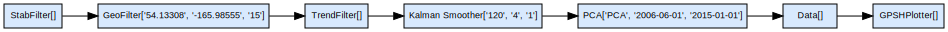

  1%|          | 2/181 [00:00<00:09, 19.35it/s]

Opening /home/caduser/CAD/data/pbo/pbo_data.h5 in read-only mode


100%|██████████| 181/181 [00:08<00:00, 22.27it/s]


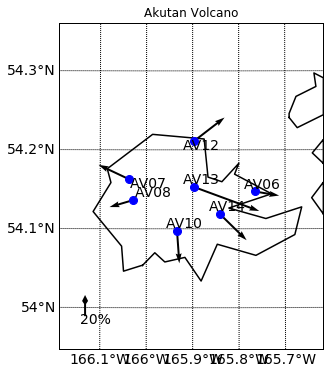

In [4]:
# Graphical flowchart of pipeline components
pipeline.plotPipelineInstance()

# Run first pass of the pipeline
pipeline.run()
plt.title('Akutan Volcano');

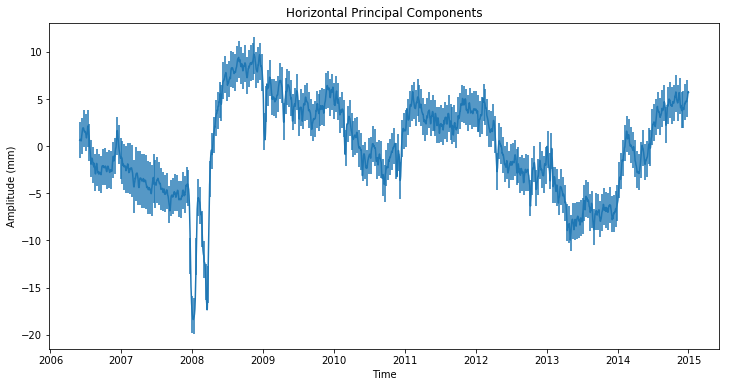

In [5]:
# PCA components
pcac = pipeline.RA_results[0]['PCA']['CA'].components_
# Processing PBO data
pdata = pipeline.RA_results[0]['Data']

# building error bars
herr_mat = [];
for site in pdata.keys():
    herr_mat.append(pdata[site].loc[ap_pca_start():ap_pca_end(),'Sn']**2)
    herr_mat.append(pdata[site].loc[ap_pca_start():ap_pca_end(),'Se']**2)
herr_mat = np.array(herr_mat)
herr_pca = np.sqrt(np.abs(np.dot(pcac**2,herr_mat))).T

# Plot 1st Horizontal PCA component
plt.figure();
plt.errorbar(pd.date_range(start=ap_pca_start(),end=ap_pca_end(),freq='D'),
             pipeline.getResults()[0]['PCA']['Projection'][:,0],
             yerr = herr_pca[:,0], errorevery=10);
plt.title('Horizontal Principal Components'); plt.xlabel('Time'); plt.ylabel('Amplitude (mm)');

#### After the above first pass, incorporate scientist's expertise
From the first-pass PCA of Akutan, the results aid the scientist in determining that:
- AV13's excessively large motion indicates some station error, and
- A transient event appears to occur in the the 09/2007 to 11/2008 range

So, for the next stage of analysis, remove AV13 from the analysis and narrow the time window for the PCA

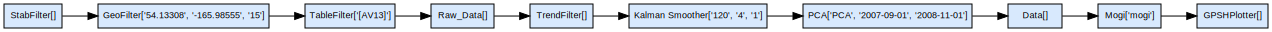

  2%|▏         | 3/181 [00:00<00:07, 22.73it/s]

Opening /home/caduser/CAD/data/pbo/pbo_data.h5 in read-only mode


100%|██████████| 181/181 [00:07<00:00, 23.12it/s]


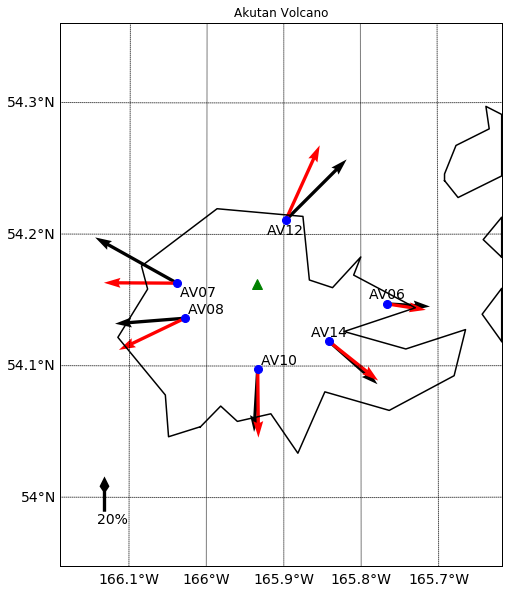

In [6]:
# First-pass PCA of Akutan aids the scientist in determining that:
# (1) AV13's excessively large motion indicates some station error
# (2) and a transient event appears to occur in the the 09/2007 to 11/2008 range

# So, for a second pass, reduce Akutan station set and remove AV13
# Table filter to remove site with bad noise
# List of labels
ap_label_list = AutoList(['AV13'])
# Create table filter
fl_table = skdiscovery.table.filters.TableFilter('TableFilter', [ap_label_list])
# Create Stage Container
sc_table = StageContainer(fl_table)

# And refine the PCA time window
ap_pca_start = AutoParam('2007-09-01')
ap_pca_end = AutoParam('2008-11-01')


# Update Relevant Stage Containers (PCA, plotter because of new Mogi stage)

# Principal Component Analysis with specified time window
ana_gca = skdiscovery.table.analysis.General_Component_Analysis('PCA', [ap_pca_type, ap_pca_start, ap_pca_end],
                                                            n_components=3, column_names=pca_column_names)
# Create stagecontainer for PCA analysis                                                       
sc_gca = StageContainer(ana_gca)

# Create GPS Horizontal Plotter for PCA and MOGI
# Create plotter item
acc_gpsplot2 = skdiscovery.generic.accumulators.GPSHPlotter('GPSHPlotter','PCA',mogi_name='Mogi',
                                                           errorEllipses=True,KF_tau=ap_kf_tau.val,map_resolution='i')
# Create Stage Container
sc_gpsplot2 = StageContainer(acc_gpsplot2)


# Add two additional stages
# Create Data Accumulator
acc_rdata = skdiscovery.generic.accumulators.DataAccumulator('Raw_Data')
# Create Stage Container for Data Accumulator
sc_rdata = StageContainer(acc_rdata)

# Mogi model estimation
# Set model type
ap_mogi_model = AutoParam('mogi')
# Set name (location) of PCA results
pca_results = 'PCA'
# Create mogi analysis item
ana_mogi = skdiscovery.table.analysis.Mogi_Inversion('Mogi', [ap_mogi_model],pca_name=pca_results)
# Create stagecontainer for mogi model
sc_mogi = StageContainer(ana_mogi)


# Recompile the pipeline from the stage containers
pipeline = DiscoveryPipeline(data_generator,[sc_stab, sc_geo, sc_table, sc_rdata,
                                             sc_tf, sc_kf, sc_gca, sc_data, sc_mogi, sc_gpsplot2])

# Graphical flowchart of pipeline components
pipeline.plotPipelineInstance()

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['svg.fonttype'] = 'none'
# Re-Run the pipeline
pipeline.run()

# Adding a figure title
plt.title('Akutan Volcano');

#### Validate the targeted analysis
The geographical result plot has improved, with no station now showing excessively significant motion.

Examination of the improved time window PCA motion and a comparison of stations on opposite sides of the volcano showing an inflation motion validate the scientist's parameter selection and the detection and measurement of a transient inflation event at Akutan.

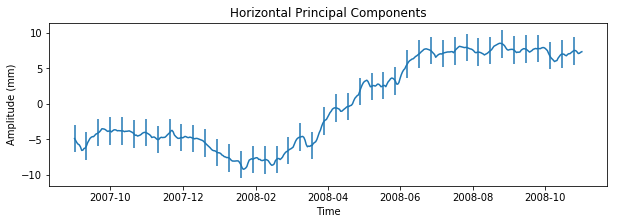

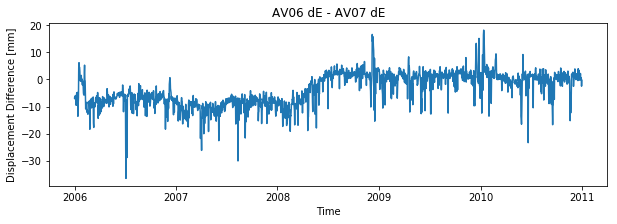

In [7]:
# Examine the improved time window PCA Results and validate the observed transient inflation event

# PCA components
pcac = pipeline.RA_results[0]['PCA']['CA'].components_
# Raw PBO data
rdata = pipeline.RA_results[0]['Raw_Data']
# Processing PBO data
pdata = pipeline.RA_results[0]['Data']

# building error bars
herr_mat = [];
for site in pdata.keys():
    herr_mat.append(pdata[site].loc[ap_pca_start():ap_pca_end(),'Sn']**2)
    herr_mat.append(pdata[site].loc[ap_pca_start():ap_pca_end(),'Se']**2)
herr_mat = np.array(herr_mat)
herr_pca = np.sqrt(np.abs(np.dot(pcac**2,herr_mat))).T

# Plot 1st Horizontal PCA component
plt.rcParams['figure.figsize'] = (10.0, 3.0)
plt.figure();
plt.errorbar(pd.date_range(start=ap_pca_start(),end=ap_pca_end(),freq='D'),
             pipeline.getResults()[0]['PCA']['Projection'][:,0],
             yerr = herr_pca[:,0], errorevery=10);
plt.title('Horizontal Principal Components'); plt.xlabel('Time'); plt.ylabel('Amplitude (mm)');

# Plot raw motion differenced between dE AV06 and AV07 as event validation 
plt.figure();
diff_06_07 = rdata['AV06'].loc[:,'dE'] - rdata['AV07'].loc[:,'dE']
plt.plot(diff_06_07[:'2010']);
plt.title('AV06 dE - AV07 dE'); plt.xlabel('Time'); plt.ylabel('Displacement Difference [mm]');

#### Test alternate model hypotheses
In addition to having detected and validated the transient inflation event, a particular Mogi model was also used to fit the results, with good agreement with the data. However, might other models give even better results? Here, a demonstration is shown for how to vary the pipeline configuration for testing multiple approaches.

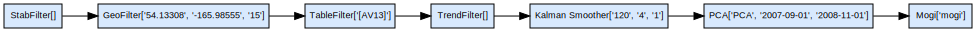

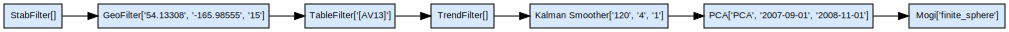

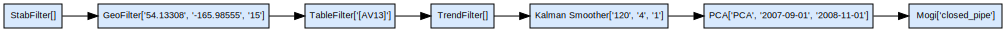

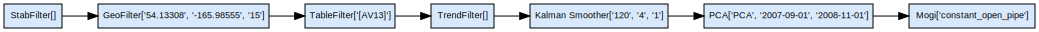

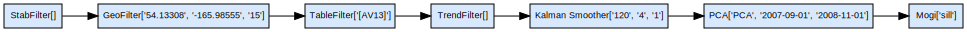

Opening /home/caduser/CAD/data/pbo/pbo_data.h5 in read-only mode


100%|██████████| 181/181 [00:08<00:00, 21.56it/s]


Opening /home/caduser/CAD/data/pbo/pbo_data.h5 in read-only mode


100%|██████████| 181/181 [00:08<00:00, 19.57it/s]


Opening /home/caduser/CAD/data/pbo/pbo_data.h5 in read-only mode


100%|██████████| 181/181 [00:08<00:00, 21.90it/s]


Opening /home/caduser/CAD/data/pbo/pbo_data.h5 in read-only mode


100%|██████████| 181/181 [00:08<00:00, 22.34it/s]


Opening /home/caduser/CAD/data/pbo/pbo_data.h5 in read-only mode


100%|██████████| 181/181 [00:08<00:00, 22.36it/s]


In [8]:
from skdiscovery.visualization import calc_distance_map

# Multiple source models estimation
# Set name (location) of PCA results
pca_results = 'PCA'
# Set model types
ap_mogi_model2 = AutoParamListCycle(('mogi','finite_sphere','closed_pipe','constant_open_pipe','sill'))
# Create mogi analysis item
ana_mogi2 = skdiscovery.table.analysis.Mogi_Inversion('Mogi', [ap_mogi_model2],
                                                      pca_name = pca_results)
# Create stagecontainer for mogi model
sc_mogi2 = StageContainer(ana_mogi2)


# Recompile the pipeline from the stage containers
pipeline2 = DiscoveryPipeline(data_generator,[sc_stab, sc_geo, sc_table, sc_tf, sc_kf, sc_gca, sc_mogi2])

# Run the pipeline multiple times to test each variant
pipeline2.run(5,verbose=True,num_cores=0)

In [9]:
calc_distance_map(pipeline2,'Mogi','Mogi','MogiVector',plotFlag=False)

,'mogi','finite_sphere','closed_pipe','constant_open_pipe','sill'
'mogi',0.000000,0.447468,0.917273,1.834815,1.825777
'finite_sphere',0.447468,0.000000,1.322831,2.135746,1.395811
'closed_pipe',0.917273,1.322831,0.000000,1.114125,2.596826
'constant_open_pipe',1.834815,2.135746,1.114125,0.000000,3.170176
'sill',1.825777,1.395811,2.596826,3.170176,0.000000


In [10]:
calc_distance_map(pipeline2,'Mogi','Mogi','MogiSource',plotFlag=False)

,'mogi','finite_sphere','closed_pipe','constant_open_pipe','sill'
'mogi',0.000000,0.090423,0.244822,0.159109,0.448413
'finite_sphere',0.090423,0.000000,0.335240,0.249385,0.357990
'closed_pipe',0.244822,0.335240,0.000000,0.086535,0.693217
'constant_open_pipe',0.159109,0.249385,0.086535,0.000000,0.607195
'sill',0.448413,0.357990,0.693217,0.607195,0.000000


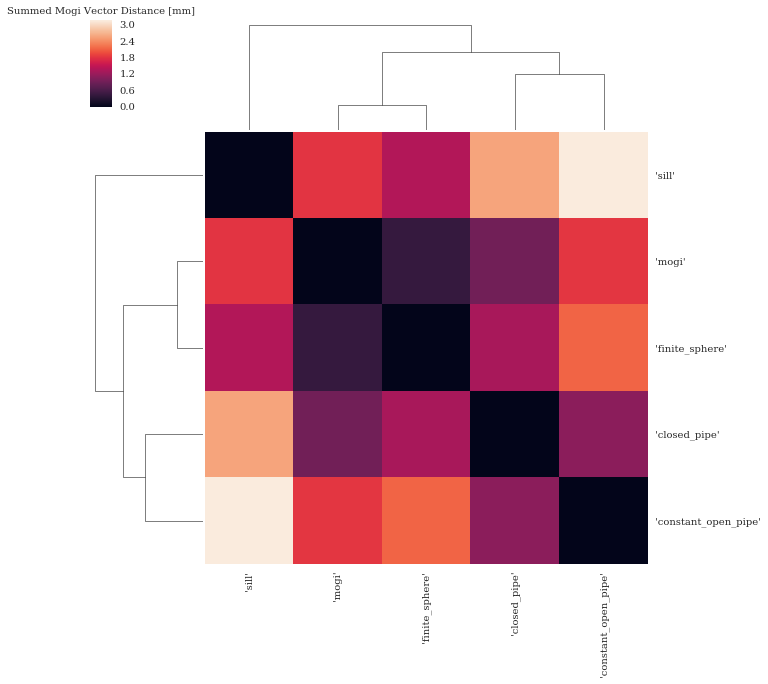

In [11]:
cm=calc_distance_map(pipeline2,'Mogi','Mogi','MogiVector',fontsize=10);
cm.cax.set_title('Summed Mogi Vector Distance [mm]',fontsize=10);